# Google Play Store Applications Analysis
Source of the dataset: https://www.kaggle.com/datasets/bhavikjikadara/google-play-store-applications

## 1 Importing Libraries

In [428]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')


## 2 Load the data

In [429]:
df = pd.read_csv(
    'dataset.csv',
    thousands=',',
    index_col=0,
)

## 3 Data Preprocessing
This may involve handling missing values, converting data types, or normalising
the data
### 3.1 Understanding the Data 

In [430]:
df.shape

(10841, 13)

In [431]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up


In [432]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.2+ MB


In [433]:
df.describe()

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


In [434]:
categories=df['Category'].value_counts()
print(categories)

Category
FAMILY                 1972
GAME                   1144
TOOLS                   843
MEDICAL                 463
BUSINESS                460
PRODUCTIVITY            424
PERSONALIZATION         392
COMMUNICATION           387
SPORTS                  384
LIFESTYLE               382
FINANCE                 366
HEALTH_AND_FITNESS      341
PHOTOGRAPHY             335
SOCIAL                  295
NEWS_AND_MAGAZINES      283
SHOPPING                260
TRAVEL_AND_LOCAL        258
DATING                  234
BOOKS_AND_REFERENCE     231
VIDEO_PLAYERS           175
EDUCATION               156
ENTERTAINMENT           149
MAPS_AND_NAVIGATION     137
FOOD_AND_DRINK          127
HOUSE_AND_HOME           88
LIBRARIES_AND_DEMO       85
AUTO_AND_VEHICLES        85
WEATHER                  82
ART_AND_DESIGN           65
EVENTS                   64
PARENTING                60
COMICS                   60
BEAUTY                   53
1.9                       1
Name: count, dtype: int64


In [435]:
df['Installs'].value_counts()

Installs
1,000,000+        1579
10,000,000+       1252
100,000+          1169
10,000+           1054
1,000+             907
5,000,000+         752
100+               719
500,000+           539
50,000+            479
5,000+             477
100,000,000+       409
10+                386
500+               330
50,000,000+        289
50+                205
5+                  82
500,000,000+        72
1+                  67
1,000,000,000+      58
0+                  14
0                    1
Free                 1
Name: count, dtype: int64

In [436]:
df['Type'].value_counts()

Type
Free    10039
Paid      800
0           1
Name: count, dtype: int64

### 3.2 Fix shifted row

In [437]:
# It seems that in a certain row the data is shifted. Let's find out which row it is

bad_row_index=df.index[df['Category'] == '1.9'].tolist()[0]

"""
This row (10472) has no category and the other columns are shifted to the left...
It also has no 'Genre'
Should we add it to the category 'PHOTOGRAPHY'?
When the category is 'PHOTOGRAPHY', is the genre always 'Photography'?
"""

"\nThis row (10472) has no category and the other columns are shifted to the left...\nIt also has no 'Genre'\nShould we add it to the category 'PHOTOGRAPHY'?\nWhen the category is 'PHOTOGRAPHY', is the genre always 'Photography'?\n"

In [438]:
# When the category is 'PHOTOGRAPHY', is the genre always 'Photography'?

df_photography=df.loc[df['Category'] == 'PHOTOGRAPHY', ['Category', 'Genres']]
df_photography.loc[df_photography['Genres'] != 'Photography']

# Yes! So we could replace category with 'PHOTOGRAPHY' and  'Genres' with 'Photography'

,Category,Genres


In [439]:
row_to_shift=df.iloc[bad_row_index]
row_to_shift

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                              1.9
Rating                                               19.0
Reviews                                              3.0M
Size                                               1,000+
Installs                                             Free
Type                                                    0
Price                                            Everyone
Content Rating                                        NaN
Genres                                          11-Feb-18
Last Updated                                       1.0.19
Current Ver                                    4.0 and up
Android Ver                                           NaN
Name: 10472, dtype: object

In [440]:
df.iloc[bad_row_index, 1:] = row_to_shift.shift(periods=1)[1:]
df.iloc[bad_row_index]

App               Life Made WI-Fi Touchscreen Photo Frame
Category          Life Made WI-Fi Touchscreen Photo Frame
Rating                                                1.9
Reviews                                              19.0
Size                                                 3.0M
Installs                                           1,000+
Type                                                 Free
Price                                                   0
Content Rating                                   Everyone
Genres                                                NaN
Last Updated                                    11-Feb-18
Current Ver                                        1.0.19
Android Ver                                    4.0 and up
Name: 10472, dtype: object

In [441]:
df.loc[bad_row_index,'Category'] = 'PHOTOGRAPHY'
df.loc[bad_row_index,'Genres'] = 'Photography'
df.iloc[bad_row_index]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                      PHOTOGRAPHY
Rating                                                1.9
Reviews                                              19.0
Size                                                 3.0M
Installs                                           1,000+
Type                                                 Free
Price                                                   0
Content Rating                                   Everyone
Genres                                        Photography
Last Updated                                    11-Feb-18
Current Ver                                        1.0.19
Android Ver                                    4.0 and up
Name: 10472, dtype: object

In [442]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   App             10841 non-null  object
 1   Category        10841 non-null  object
 2   Rating          9367 non-null   object
 3   Reviews         10841 non-null  object
 4   Size            10841 non-null  object
 5   Installs        10841 non-null  object
 6   Type            10840 non-null  object
 7   Price           10841 non-null  object
 8   Content Rating  10841 non-null  object
 9   Genres          10841 non-null  object
 10  Last Updated    10841 non-null  object
 11  Current Ver     10833 non-null  object
 12  Android Ver     10839 non-null  object
dtypes: object(13)
memory usage: 1.4+ MB


### 3.3 Data Cleaning -> Changing the data types to numeric or date values and handling missing values
#### 3.3.1 Changing 'Rating' to numeric

In [443]:
# Checking that all rating are from [1, 5]
for i in df['Rating'].unique():
    i = float(i)
    if i < 1 or i > 5:
        print(i)
# There are none

In [444]:
def convert_to_numeric(x):
    num = None
    
    if isinstance(x, str):
        if ',' in x:
            x = x.replace(',', '')
        if '+' in x:
            x = x.replace('+', '')
        if '$' in x:
            x = x.replace('$', '')
        if "\"" in x:
            x = x.replace('\"', '')
        
        if 'M' in x:
            num =  float(x.replace('M', '')) * 10**6
        elif 'k' in x:
            num =  float(x.replace('k', '')) * 10**3
        elif '.' in x:
            num =  float(x)

        
        else:
            num =  float(x)

        return num
    
    return x

# Apply the function to the 'Rating' column
df['Rating'] = df['Rating'].apply(convert_to_numeric)

df['Rating'].describe()

count    9367.000000
mean        4.191513
std         0.515735
min         1.000000
25%         4.000000
50%         4.300000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64

#### 3.3.2 Changing 'Reviews' to numeric

In [445]:
df['Reviews'] = df['Reviews'].astype(int)
df['Reviews'].describe()

count    1.084100e+04
mean     4.441119e+05
std      2.927629e+06
min      0.000000e+00
25%      3.800000e+01
50%      2.094000e+03
75%      5.476800e+04
max      7.815831e+07
Name: Reviews, dtype: float64

#### 3.3.2 Changing Size to numeric

In [446]:
df.replace({'Size': 'Varies with device'}, pd.NA, inplace=True)
df['Size'] = df['Size'].apply(convert_to_numeric)
df['Size'] = pd.to_numeric(df['Size'], errors='coerce')
df['Size'].describe()

count    9.146000e+03
mean     2.151450e+07
std      2.258834e+07
min      8.500000e+03
25%      4.900000e+06
50%      1.300000e+07
75%      3.000000e+07
max      1.000000e+08
Name: Size, dtype: float64

In [447]:
# We know that the size is in megabytes, so we can convert the size to megabytes
df['Size'] = df['Size'].apply(lambda x: x / 10**6)
df['Size'].describe()

count    9146.000000
mean       21.514505
std        22.588343
min         0.008500
25%         4.900000
50%        13.000000
75%        30.000000
max       100.000000
Name: Size, dtype: float64

#### 3.3.3 Changing Installs to numeric

In [448]:
df['Installs'] = df['Installs'].str.replace('+', '')
df['Installs'] = df['Installs'].str.replace(',', '')
df['Installs'] = df['Installs'].astype(int)
df['Installs'].describe()

count    1.084100e+04
mean     1.546291e+07
std      8.502557e+07
min      0.000000e+00
25%      1.000000e+03
50%      1.000000e+05
75%      5.000000e+06
max      1.000000e+09
Name: Installs, dtype: float64

#### 3.3.4 Changing Price to numeric

In [449]:
df['Price'] = df['Price'].str.replace('$', '')
df['Price'] = df['Price'].astype(float)
df['Price'].describe()

count    10841.000000
mean         1.027273
std         15.948971
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        400.000000
Name: Price, dtype: float64

#### 3.3.5 Changing Last Updated to date

In [450]:
df['Last Updated'] = pd.to_datetime(df['Last Updated'], format='%d-%b-%y', errors="coerce")

#### 3.3.6 Deleting repeated rows

In [451]:
# Deleting repeated rows
df.drop_duplicates(inplace=True)

"""
There are still some apps that appear more than once so we will keep the one with the latest 'Last Updated' date
"""
# Sort the DataFrame by 'Last Updated' column in descending order
df.sort_values(by='Last Updated', ascending=False, inplace=True)

# Drop duplicates keeping only the first occurrence (since it's sorted in descending order)
df.drop_duplicates(subset='App', keep='first', inplace=True)

# If you want to reset the index after dropping duplicates
df.reset_index(drop=True, inplace=True)


#### 3.3.7 Checking if an app is free, its price should be 0

In [452]:
# Changing an app's 'Type' to 'Paid' if the price is greater than 0
# Replace 'Type' with 'Paid' where the price is greater than 0
df.loc[df['Price'] > 0, 'Type'] = 'Paid'

# Deleting the 'Type' column sinze it is no longer needed
df.drop(columns='Type', inplace=True)

#### 3.3.8 Handling missing values (Dropping rows with missing values)

In [453]:
# Drop rows with missing values
df.dropna(inplace=True)

### 3.4 Reviewing the data after cleaning

In [454]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7020 entries, 1 to 9659
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   App             7020 non-null   object        
 1   Category        7020 non-null   object        
 2   Rating          7020 non-null   float64       
 3   Reviews         7020 non-null   int64         
 4   Size            7020 non-null   float64       
 5   Installs        7020 non-null   int64         
 6   Price           7020 non-null   float64       
 7   Content Rating  7020 non-null   object        
 8   Genres          7020 non-null   object        
 9   Last Updated    7020 non-null   datetime64[ns]
 10  Current Ver     7020 non-null   object        
 11  Android Ver     7020 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(6)
memory usage: 713.0+ KB


In [455]:
# For every column, get the value counts in descending order and take the index (value) of most common value
most_common = df.mode().iloc[0]
most_common

App                            #NAME?
Category                       FAMILY
Rating                            4.4
Reviews                           2.0
Size                             14.0
Installs                    1000000.0
Price                             0.0
Content Rating               Everyone
Genres                          Tools
Last Updated      2018-08-03 00:00:00
Current Ver                         1
Android Ver                4.1 and up
Name: 0, dtype: object

In [456]:
df.head(10)

,App,Category,Rating,Reviews,Size,Installs,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
1,Shoot Hunter-Gun Killer,GAME,4.3,320334,27.0,50000000,0.00,Teen,Action,2018-08-08,1.1.2,4.1 and up
2,Fast Tract Diet,HEALTH_AND_FITNESS,4.4,35,2.4,1000,7.99,Everyone,Health & Fitness,2018-08-08,1.9.3,4.2 and up
3,BankNordik,FINANCE,3.9,28,15.0,5000,0.00,Everyone,Finance,2018-08-08,7.3.2,5.0 and up
4,Video Downloader For FB: Save FB Videos 2018,TOOLS,4.3,434,3.6,50000,0.00,Everyone,Tools,2018-08-08,1.1.9,4.0.3 and up
5,Justice League Action Run,GAME,4.3,22333,9.7,1000000,0.00,Everyone 10+,Action,2018-08-07,2.01,4.3 and up
7,Monster Fishing 2018,SPORTS,4.4,32881,76.0,1000000,0.00,Everyone,Sports,2018-08-07,0.0.80,4.1 and up
9,Premier League - Official App,SPORTS,4.3,63782,24.0,5000000,0.00,Everyone,Sports,2018-08-07,1.1.5,4.1 and up
11,Masha and The Bear Jam Day Match 3 games for kids,FAMILY,4.6,50060,98.0,1000000,0.00,Everyone,Puzzle;Brain Games,2018-08-07,1.4.83,4.1 and up
13,FC Red Bull Salzburg App,SPORTS,4.5,1526,89.0,50000,0.00,Everyone,Sports,2018-08-07,4.0.4-R,5.0 and up
15,HipChat - beta version,COMMUNICATION,4.1,1035,20.0,50000,0.00,Everyone,Communication,2018-08-07,3.20.001,4.1 and up


## 4 Data Analysis

### 4.1 Descriptive Statistics


In [457]:
for col in df.select_dtypes(include='number').columns:
    print(f"{'='*30}\n{col.upper()}\n{'='*30}")
    print(f"{'Mean:':<20} {df[col].mean()}")
    print(f"{'Median:':<20} {df[col].median()}")
    print(f"{'Mode:':<20} {df[col].mode().iloc[0]}")
    print(f"{'Standard Deviation:':<20} {df[col].std()}")
    print()

RATING
Mean:                4.160413105413105
Median:              4.3
Mode:                4.4
Standard Deviation:  0.5595126410521235

REVIEWS
Mean:                145076.26994301996
Median:              1550.5
Mode:                2
Standard Deviation:  1024540.946614351

SIZE
Mean:                21.771773433048434
Median:              13.0
Mode:                14.0
Standard Deviation:  22.73207283552189

INSTALLS
Mean:                4478922.167806268
Median:              100000.0
Mode:                1000000
Standard Deviation:  27156392.213120084

PRICE
Mean:                1.171542735042735
Median:              0.0
Mode:                0.0
Standard Deviation:  18.20597837708227



In [458]:
# For every column if it is of data type object, print the value counts of the column
for col in df.select_dtypes(include='object').columns:
    print(f"Column: {col}")
    print(df[col].value_counts())
    print()

Column: App
App
Shoot Hunter-Gun Killer                    1
Aster DM Healthcare                        1
boattheory.ch Full 2018                    1
Calculator with Percent (Free)             1
Nuke Em All                                1
                                          ..
My Child from eDziecko.pl                  1
Adivina el cantante de Trap y Reggaeton    1
Offroad drive : 4x4 driving game           1
Carrier Landings Pro                       1
FML F*ck my life + widget                  1
Name: count, Length: 7020, dtype: int64

Column: Category
Category
FAMILY                 1537
GAME                    818
TOOLS                   626
PERSONALIZATION         274
LIFESTYLE               269
MEDICAL                 266
FINANCE                 258
PRODUCTIVITY            223
SPORTS                  221
BUSINESS                221
PHOTOGRAPHY             205
HEALTH_AND_FITNESS      191
COMMUNICATION           189
SOCIAL                  156
NEWS_AND_MAGAZINES      154
SH

### 4.2 Data Visualisation

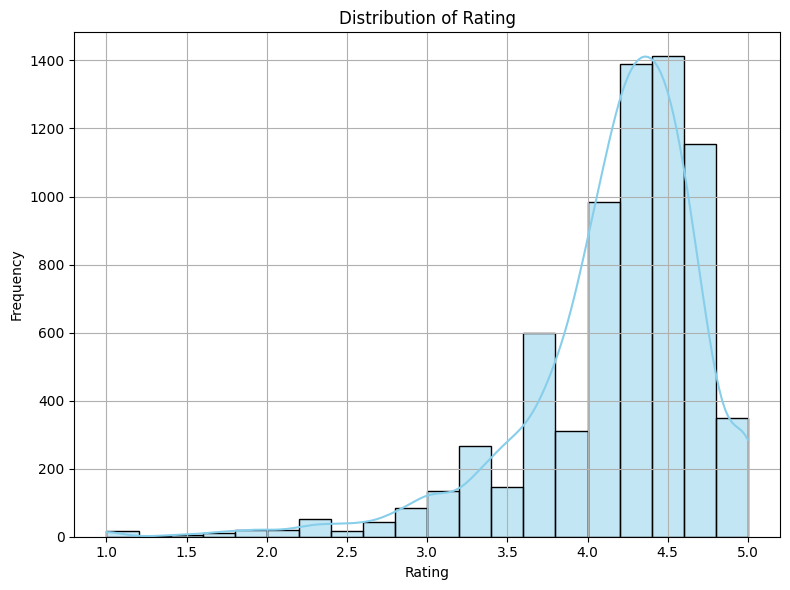

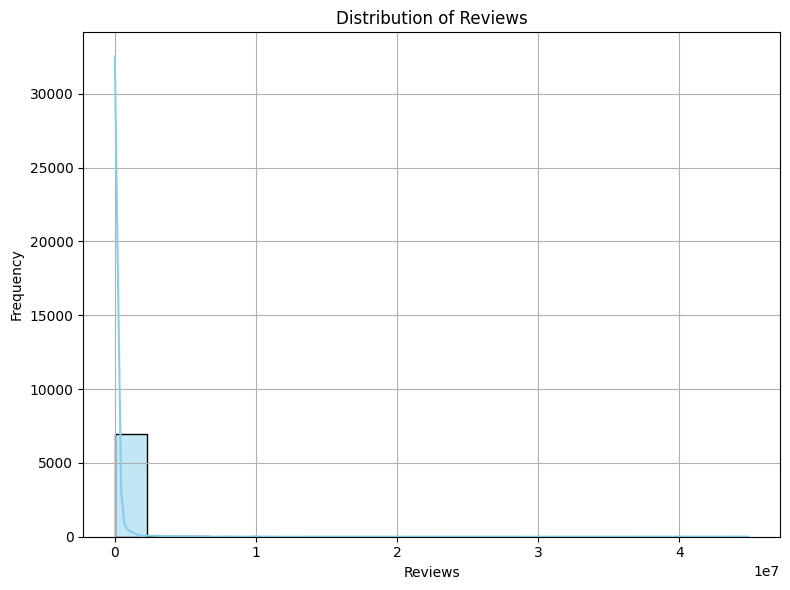

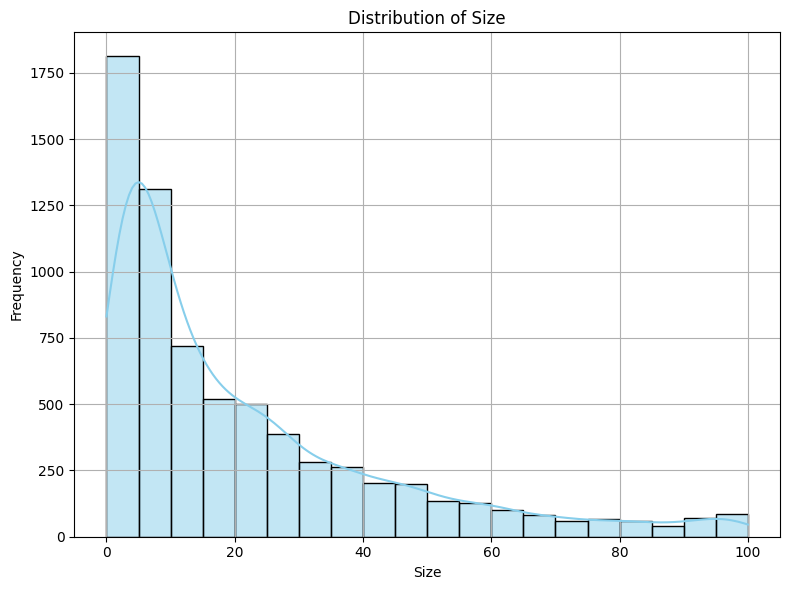

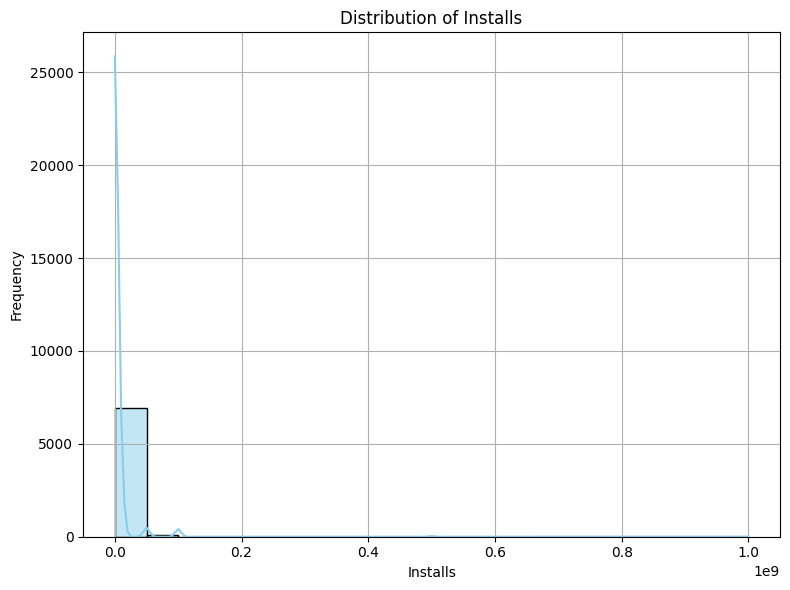

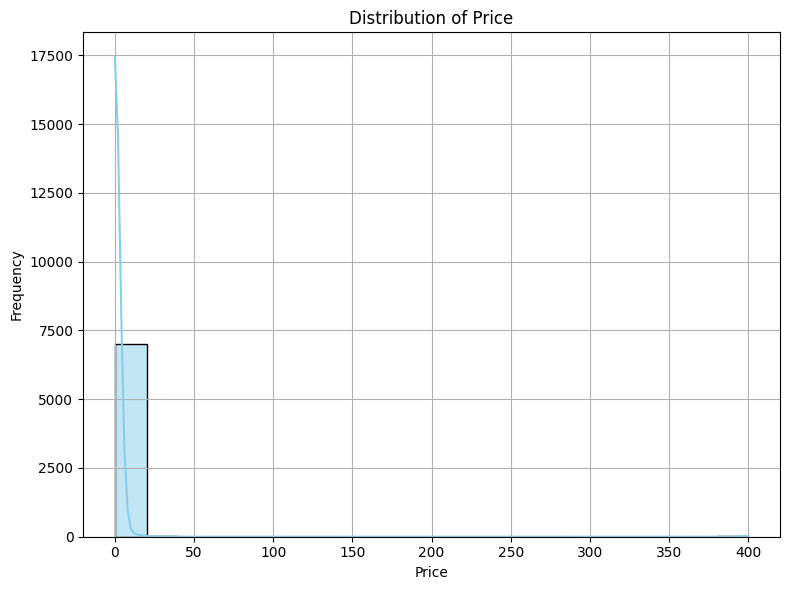

In [459]:
# Histograms, Box Plots, and Scatter plots
# Adjust the appearance of numerical columns
for col in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(8, 6))  # Adjust the figure size
    sns.histplot(df[col], bins=20, kde=True, color='skyblue')  # Adjust the number of bins and add kernel density estimation (kde)
    plt.xlabel(col.capitalize())  # Add x-axis label with capitalized column name
    plt.ylabel('Frequency')  # Add y-axis label
    plt.title(f'Distribution of {col.capitalize()}')  # Add a descriptive title
    plt.grid(True)  # Add gridlines
    plt.tight_layout()  # Adjust layout to prevent overlapping elements
    plt.show()

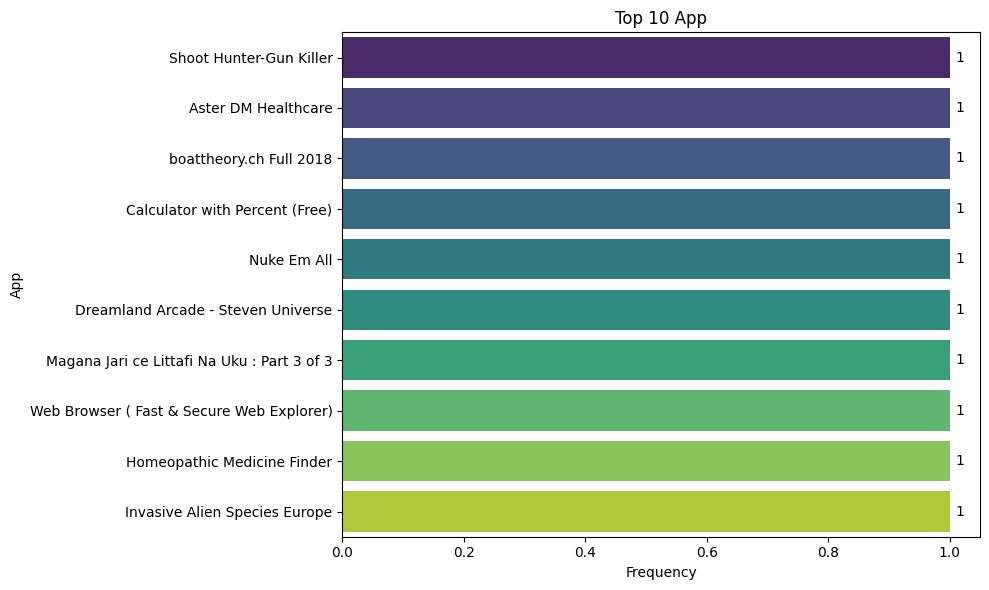

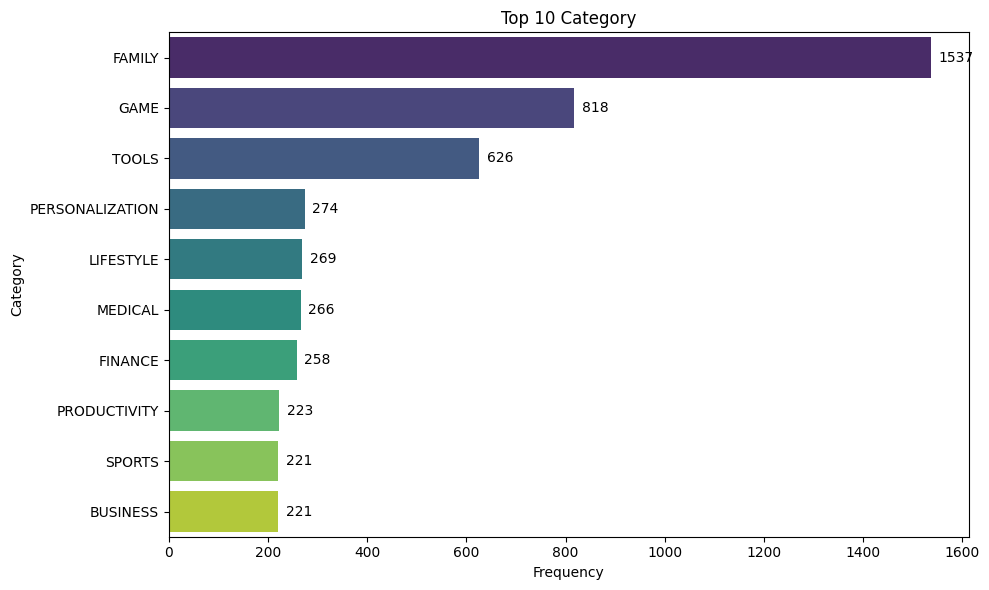

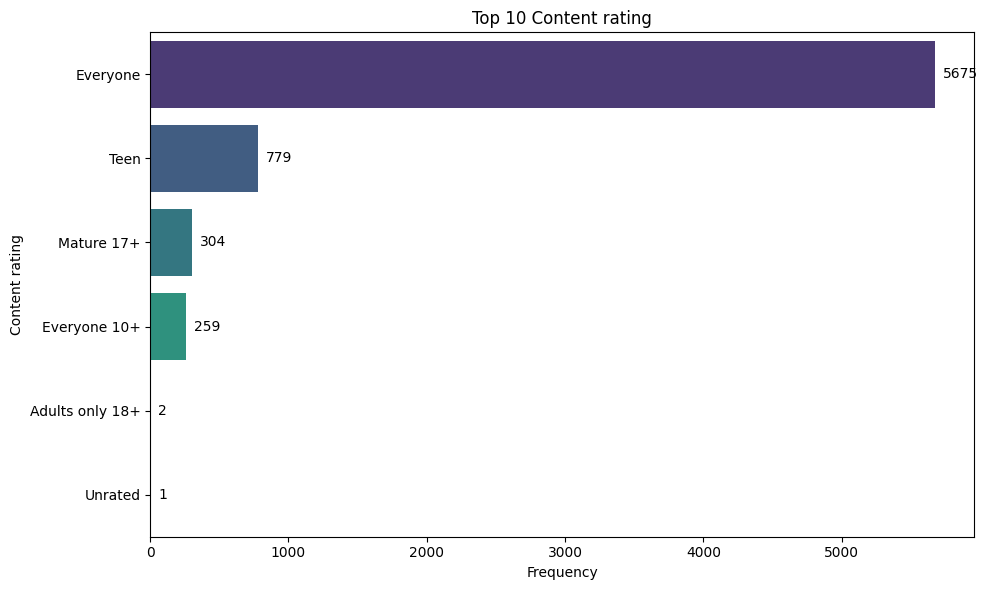

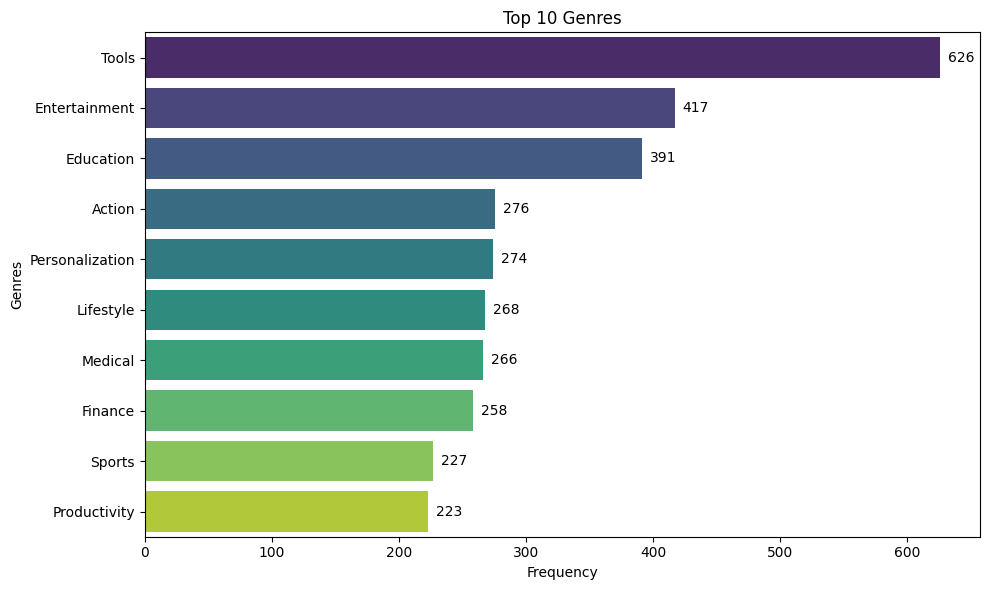

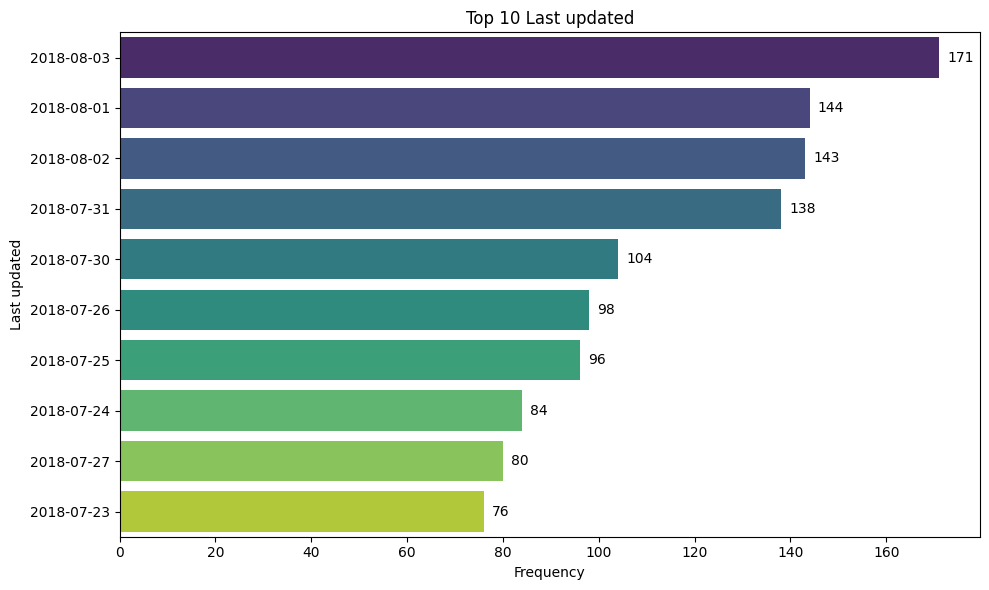

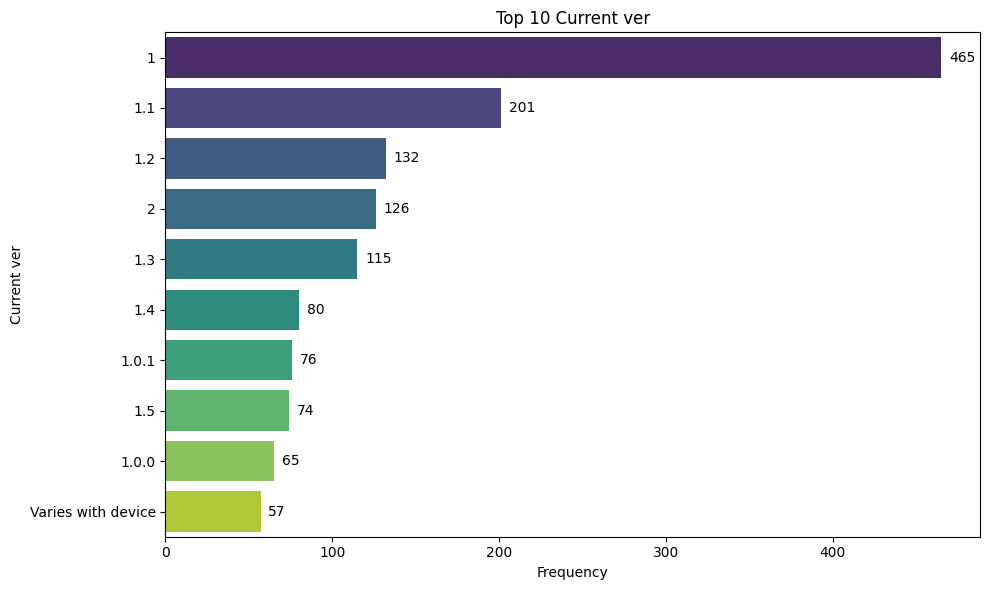

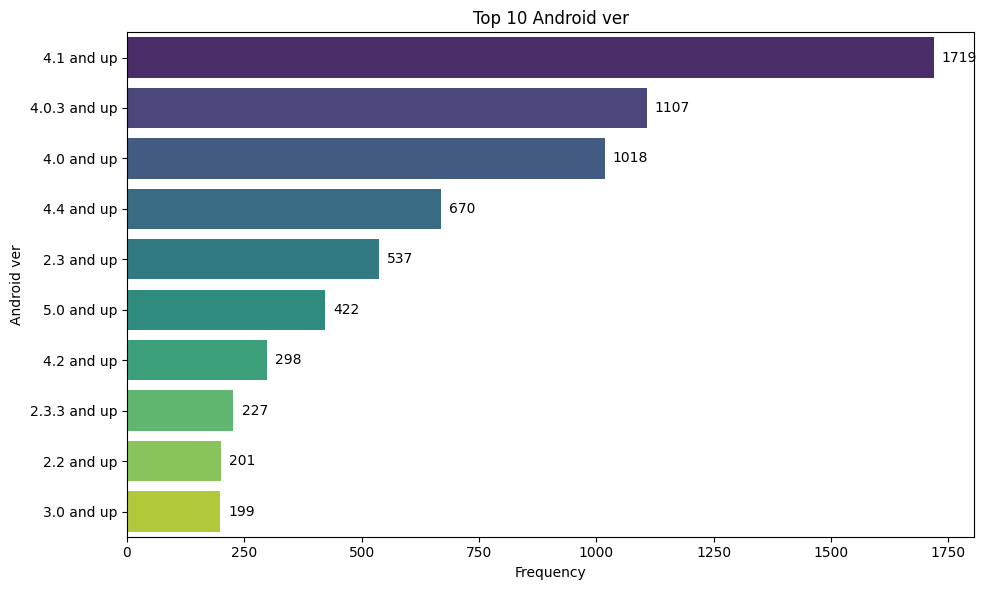

In [460]:
non_numeric_columns = df.select_dtypes(exclude='number').columns

# Loop through non-numeric columns and create count plots for the top 10 most frequent values
for col in non_numeric_columns:
    top_10_values = df[col].value_counts().nlargest(10)  # Get the top 10 most frequent values
    plt.figure(figsize=(10, 6))  # Adjust the figure size
    ax = sns.barplot(x=top_10_values.values, y=top_10_values.index, palette='viridis', ci=None)  # Create a bar plot with seaborn, ci=None to remove confidence intervals
    plt.xlabel('Frequency')  # Add x-axis label
    plt.ylabel(col.capitalize())  # Add y-axis label with capitalized column name
    plt.title(f'Top 10 {col.capitalize()}')  # Add a descriptive title

    # Annotate each bar with its value
    for i, v in enumerate(top_10_values.values):
        ax.text(v + max(top_10_values.values) * 0.01, i, str(v), color='black', va='center')  # Adjust position of the annotation relative to the bar width

    plt.tight_layout()  # Adjust layout to prevent overlapping elements
    plt.show()
